# Fitting a 1D fault slip model to data from the San Andreas fault

Gareth Funning, University of California, Riverside

To demonstrate some very simple features of nonlinear models, I will use one of the very simplest models out there $-$ the 1D model for strike-slip, as popularized by [Savage and Burford (1973)](https://doi.org/10.1029/JB078i005p00832).

## 1. Dependencies 

If you don't have these things installed, you're probably in the wrong conda environment!

In [2]:
import numpy as np
import pygmt

## 2. The 1D model for strike-slip

Although it is most commonly known as the Savage and Burford model, the 1D model for strike-slip, or more precisely, for a screw dislocation in an elastic half space, was originally derived by Weertman and Weertman (1964). It makes several simplifying assumptions:

- The fault is vertical
- The fault is infinitely long
- The fault extends infinitely deep, beneath a locking depth, $D$
- The fault is locked above the locking depth
- The fault is stably sliding at a constant, uniform rate, $s$, beneath the locking depth

The model describes how the surface deformation rate, $v$, varies as a function of distance, $x$, from the fault. (There are also expressions for strain rate, $e$, which are effectively the spatial derivative of v, but we won't get into that today.) That relationship is analytical, and simple to evaluate:

$$ v = \frac{s}{\pi} \arctan\left(\frac{x}{D}\right)+v_{shift}$$

where $v_{shift}$ is a shift in velocity to account for the difference between zero in the model and any overall regional motion (e.g. due to plate tectonics).

**Looking at the function that describes the model, what are the parameters? Are any of them linear? Are any of them nonlinear?**

The model is often associated with Savage and Burford, two researchers from the USGS, who in 1973 published their application of the model to EDM (Electronic Distance Measurement, not dance music) data from the San Andreas fault system in California. One of the figures in the paper is something of a classic: 

![Savage and Burford figure](https://raw.githubusercontent.com/geniusinaction/GEO244/refs/heads/main/08_nonlinear_inverse_models/savage_burford_1973.png)

The top panel shows the model geometry (left), the theoretical strain rate distribution (center) and expected displacement (or velocity) profile (right). The lower panel shows the same, but for a fault that is stably sliding from the surface (what you would expect if a fault was creeping at its long-term slip rate).


## 3. Evaluating the 1D model

As the model is simple, we can evaluate it easily in Python. We can try to see what happens when we vary the input parameters.

First, we can make a function to evaluate the model to make things simpler. Then we can use PyGMT to plot it.

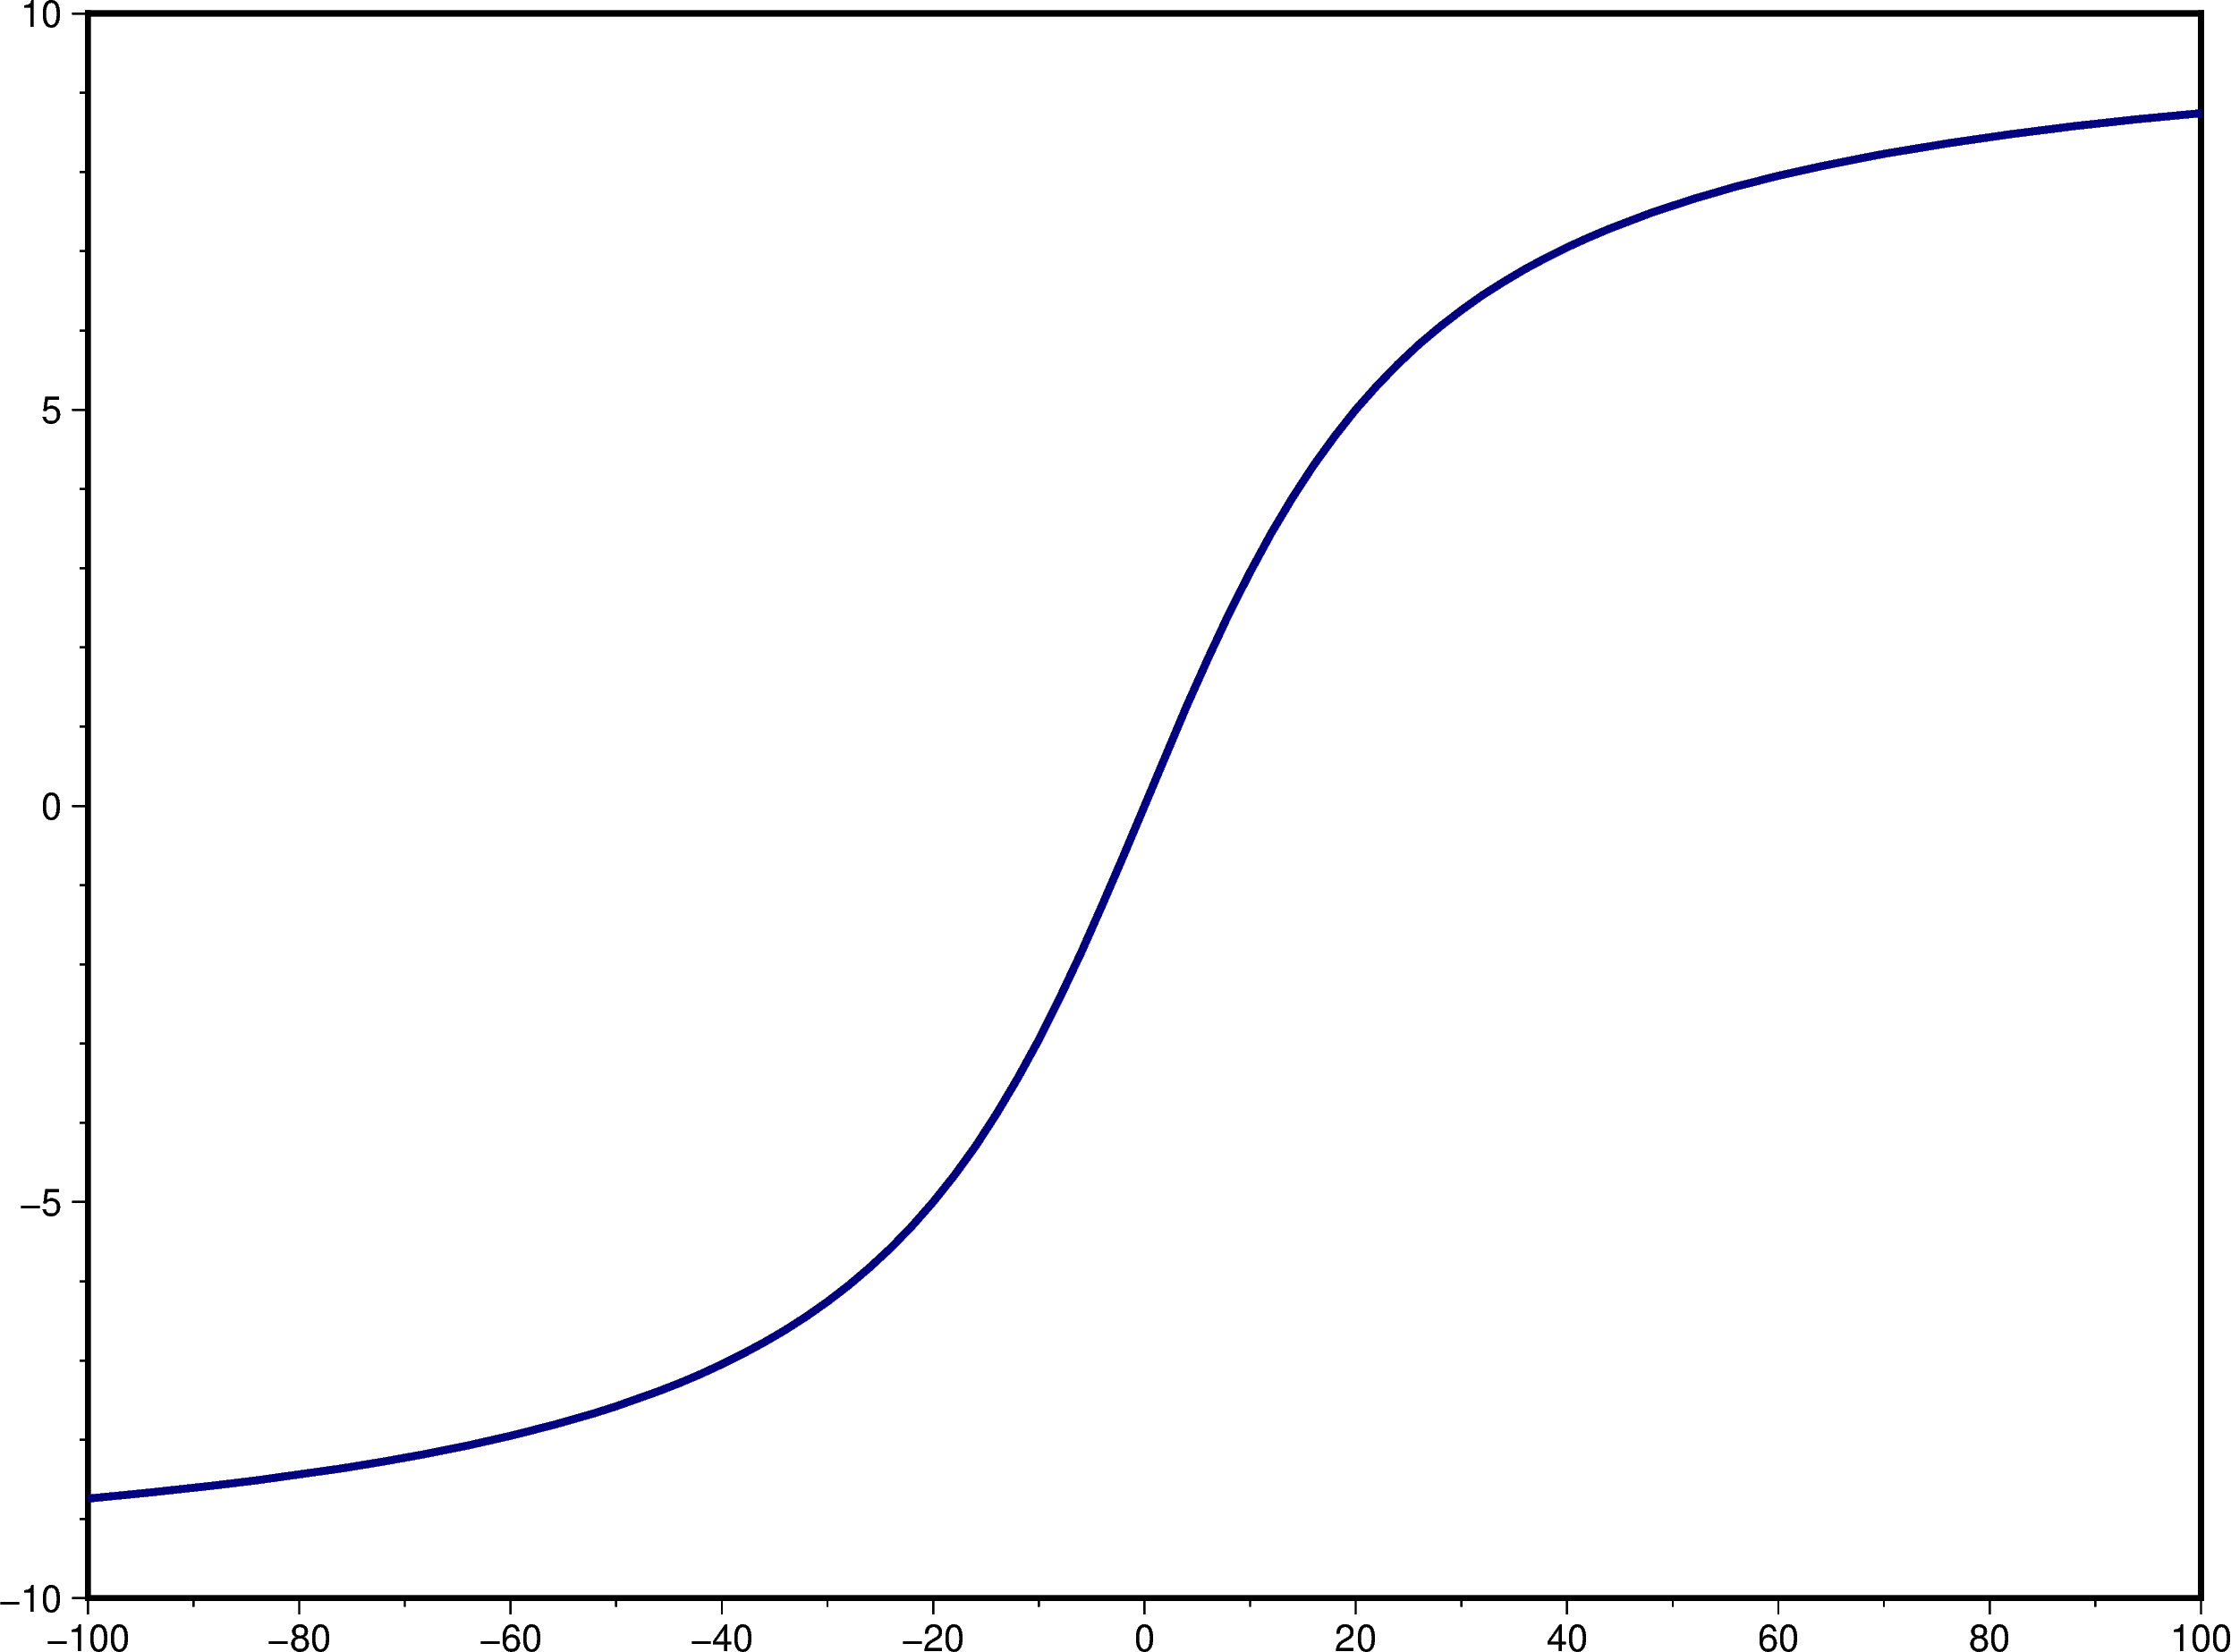

In [3]:
# let's define a function for the 1d model:
def slip1d(s, D, v_shift, x):
    v=(s/np.pi)*np.arctan(x/D)+v_shift
    return v

# let's establish some parameter/input values

s=20        # slip rate in mm/yr, positive left-lateral
D=20        # locking depth in km
v_shift=0   # velocity shift in mm/yr

x=np.linspace(-100,100,101)  # an array of distances in km

# and evaluate it!

v=slip1d(s,D,v_shift,x)

# let's plot it to see what we got

region = [np.min(x), np.max(x), -s/2, s/2]

fig = pygmt.Figure()
fig.basemap(region=region,projection='X20c/15c',frame=True)
#fig.plot(data=gps_data,style='c0.1c',fill='black',error_bar='y')
fig.plot(x=x,y=v,pen='2p,navy')
fig.show()


## 4. Solving for a real slip rate and locking depth

Let's try and get hold of some real GNSS data for the San Andreas! Schmalzle et al. (2006) used campaign GNSS survey data from the 1990s and 2000s to constrain its slip rate. The paper is here: https://doi.org/10.1029/2005JB003843

Table 3 of the paper has the relevant data. Can we load it in somehow? And plot it? Note that the fault-parallel velocities are included with their uncertainties $-$ can we load all of those in?

In [4]:
# let's extract the data from the tables in schmalzle et al...

# extract the site names from the Table 3 file
!cat schmalzle_gnss_velocities.txt | awk '{if((NR>5)&&(NR<28))print $1}' > gps_names.txt

# extract horizontal gnss velocities and their uncertainties from the Table 3 file
!cat schmalzle_gnss_velocities.txt | awk -F'\t+' '{if((NR>5)&&(NR<28)) if($4=="-")print $2, $3; else print $4, $5}' | awk '{print $1, $3, $4, $6}' > gps_velocities.txt

# extract site coordinates from the Table 2 file
!cat schmalzle_gnss_locations.txt | awk -F'\t' '{if((NR>3)&&(NR<26))print $2, $3}' > gps_locations.txt 

# stick them all together for funsies
#!paste gps_locations.txt gps_velocities.txt gps_names.txt

# make a kml file of the stations
!paste gps_locations.txt gps_names.txt | awk '{printf("%f  %f \"%s\"\n",$1, $2, $3)}' | gmt 2kml -Ag0 -Fs -Nt -Sc0.2c -W1p -Gred+f > gps_stations.kml

# project the gps stations onto a strike-perpendicular profile line
# strike is 140 degrees, so profile line azimuth is 50 degrees 
!gmt project gps_locations.txt -C-119.923742/35.368309 -A50 -Q | awk '{print $3}' > gps_distances.txt

unit strike vector:  0.6427876096865395 -0.7660444431189779


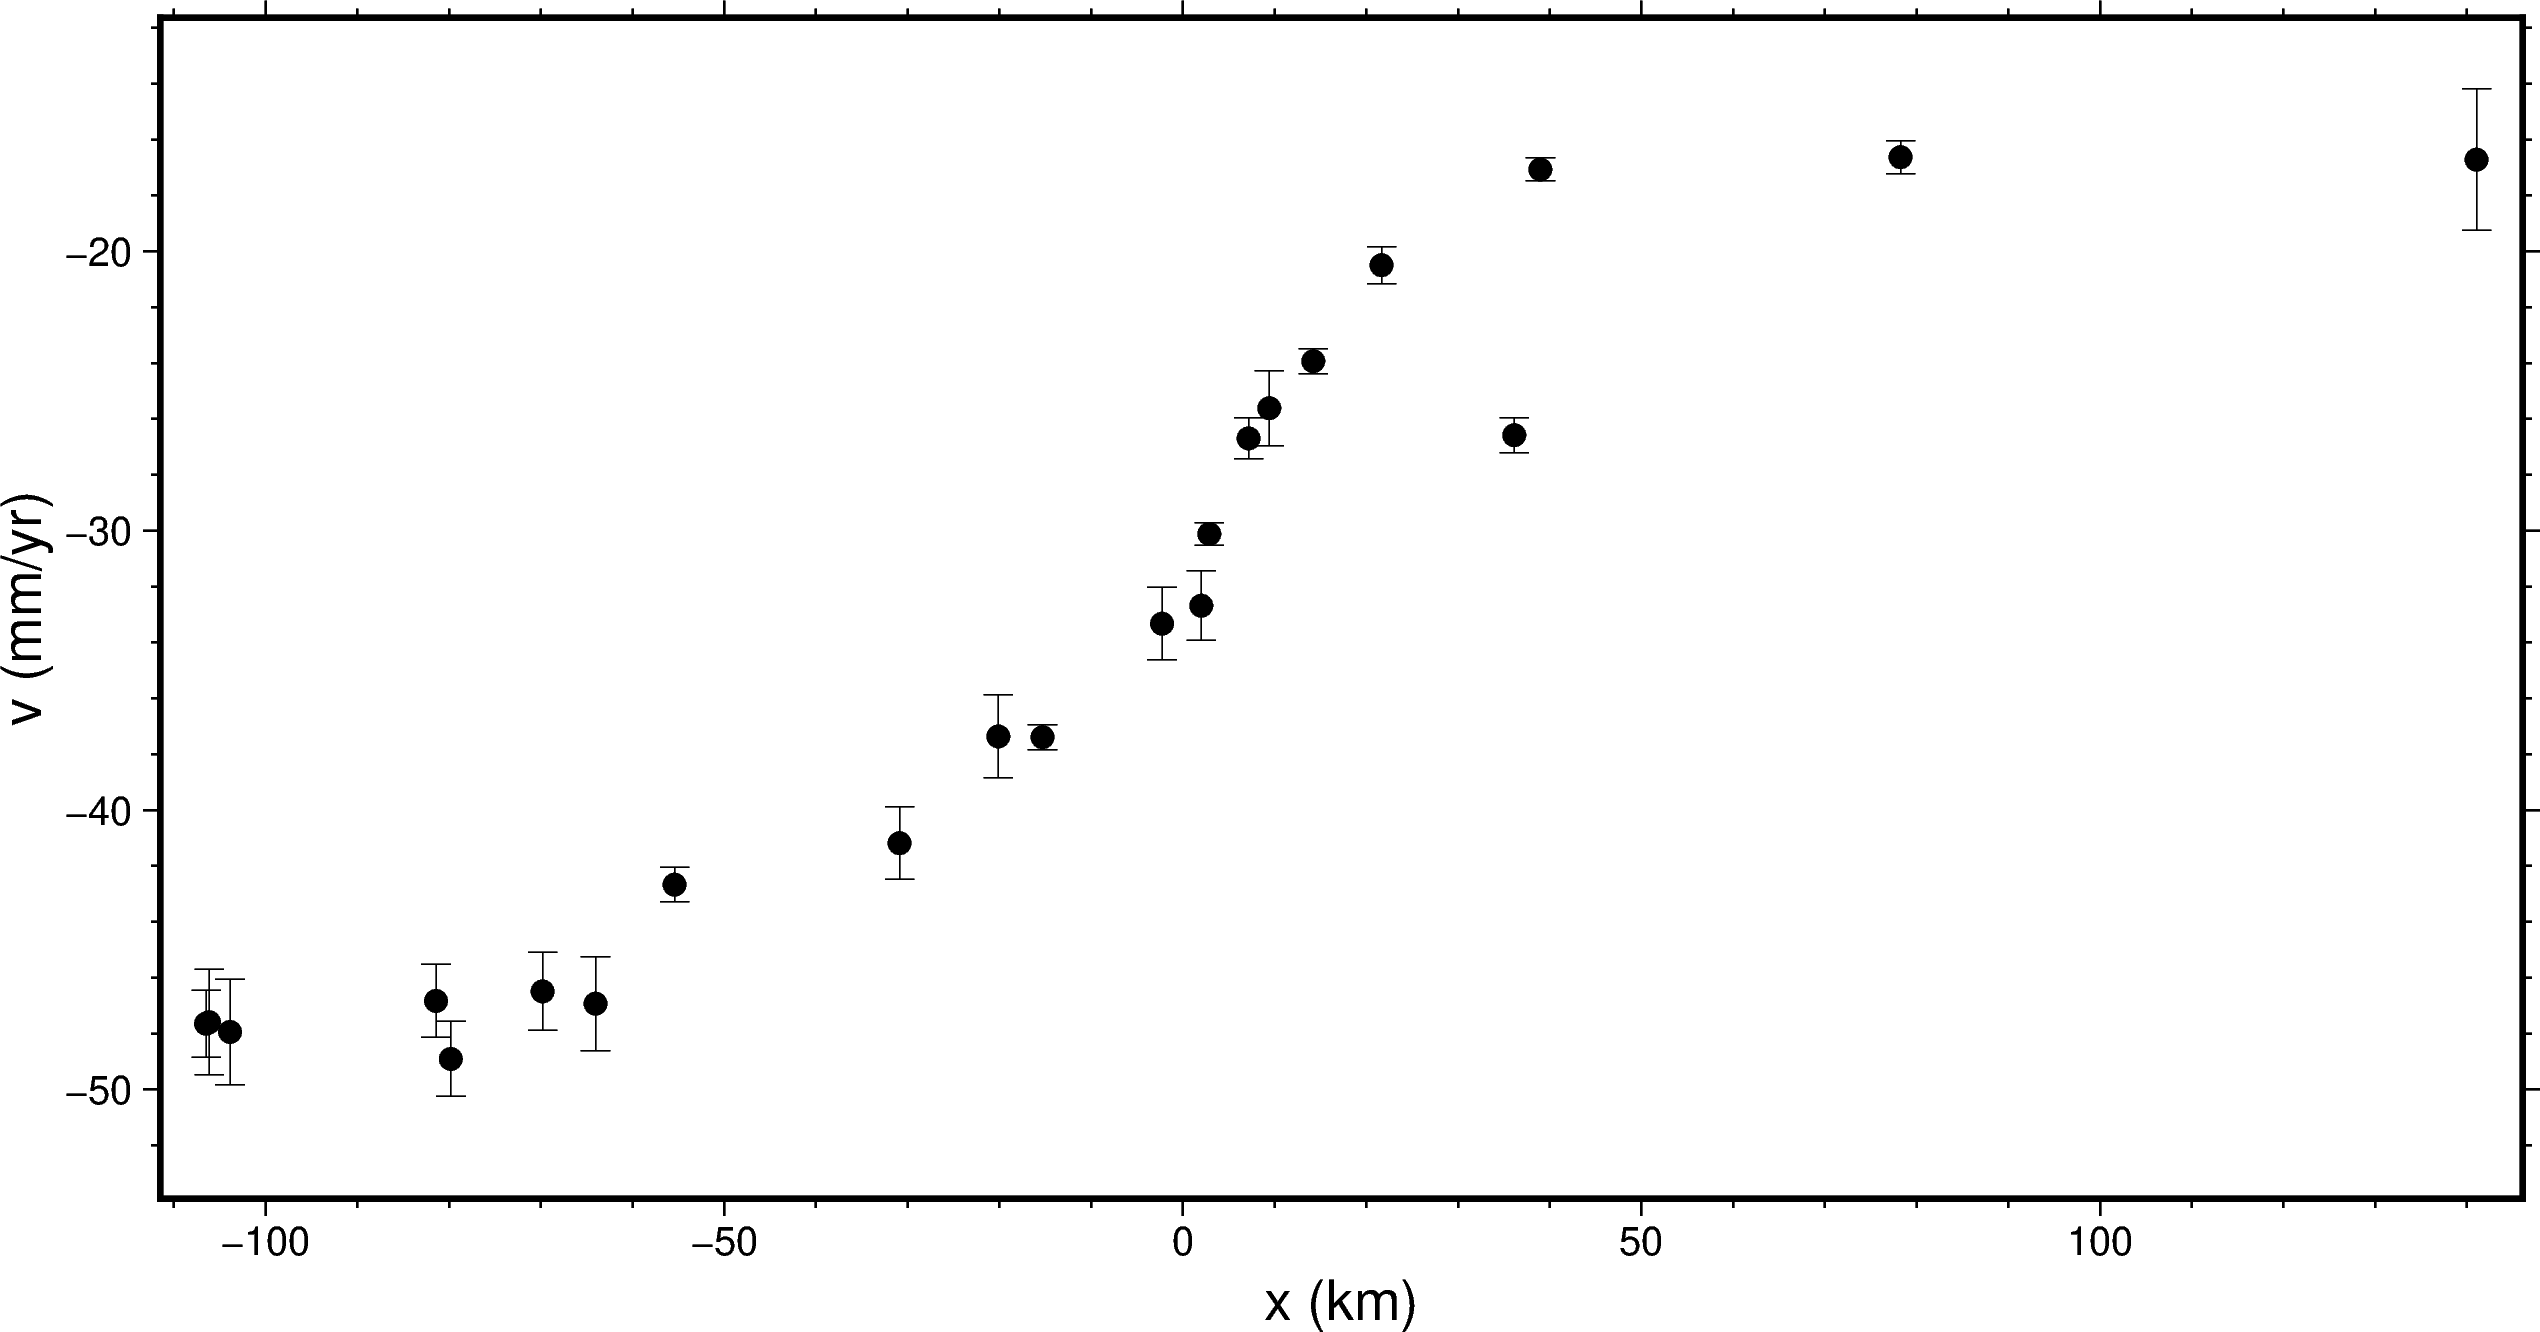

In [5]:
# load in the distances
x_gps=np.loadtxt('gps_distances.txt')

# load in the gps velocities
horiz_gps=np.loadtxt('gps_velocities.txt')

# set the strike
str=140

# and make a unit vector in the strike direction
dx=np.sin(np.radians(str))  # x component
dy=np.cos(np.radians(str))  # y component
print("unit strike vector: ",dx,dy)

# project the horizontal velocities into the strike direction using this unit vector
# (effectively, this is taking the dot product between the velocity vector and the strike vector)
v_gps=horiz_gps[:,0]*dx + horiz_gps[:,2]*dy

# project the hotizontal velocity uncertainties into the strike direction as well
v_gps_err=np.sqrt(dx**2*horiz_gps[:,1]**2 + dy**2*horiz_gps[:,3]**2)

# plot the points to check...
region = [np.min(x_gps)-5, np.max(x_gps)+5,  np.min(v_gps)-5, np.max(v_gps)+5]
fig = pygmt.Figure()
fig.basemap(region=region,projection='X20c/10c',frame=['WeSn','xa50f10+lx (km)','ya10f2+lv (mm/yr)'])
#fig.plot(data=np.vstack((x_gps,v_gps)).T,style='c0.2',fill='black')
fig.plot(data=np.vstack((x_gps,v_gps,v_gps_err)).T,style='c0.2c',fill='black',error_bar='y')
fig.show()

Notice anything about the sign of the data? Should we do anything about that, and if so, what?

Next, we should think about how we might perform some kind of grid search to solve for the slip rate and locking depth of the San Andreas. The code snippet below is one way of trying to establish some arrays of values over which to evaluate the model. (I would seriously recommend changing these, they were included to give you some idea of syntax, not because they have the correct values!) 

In [6]:
# set minimum and maximum slip rate bounds, plus a step size
smin=5
smax=50
sstep=5

# make a range of possible slip rate values
slip_rates=np.arange(smin,smax+sstep,sstep)

# set minimum and maximum locking depth bounds, plus a step size
Dmin=5
Dmax=25
Dstep=4

# make a range of possible locking depth values
locking_depths=np.arange(Dmin,Dmax+Dstep,Dstep)

Next, we should try to calculate the fit of a model to the data. One metric we can use is the total squared misfit, also known as the 'Residual Sum of Squares' or *RSS*:

$$ RSS = \sum_{i=1}^N (v_i - v_i')^2 $$

where $N$ is the number of data points, $v_i'$ are the predicted values of the data from the model, and $v_i$ are the observed data values. In vector/matrix form, this becomes:

$$ RSS = (\bf{v - v'})^T (\bf{v-v'}) $$

If you are able to form an inverse covariance matrix, $\bf{E^{-1}}$, based on the uncertainties of the data, you can use it to estimated the Weighted Residual Sum of Squares (*WRSS*) like so:

$$ WRSS = (\bf{v - v'})^T \bf{E^{-1}}(\bf{v-v'}) $$

**Hint**: The `np.diag` function will allow you to make a diagonal matrix out of a numpy array, which might be useful for making $\bf{E^{-1}}$. 

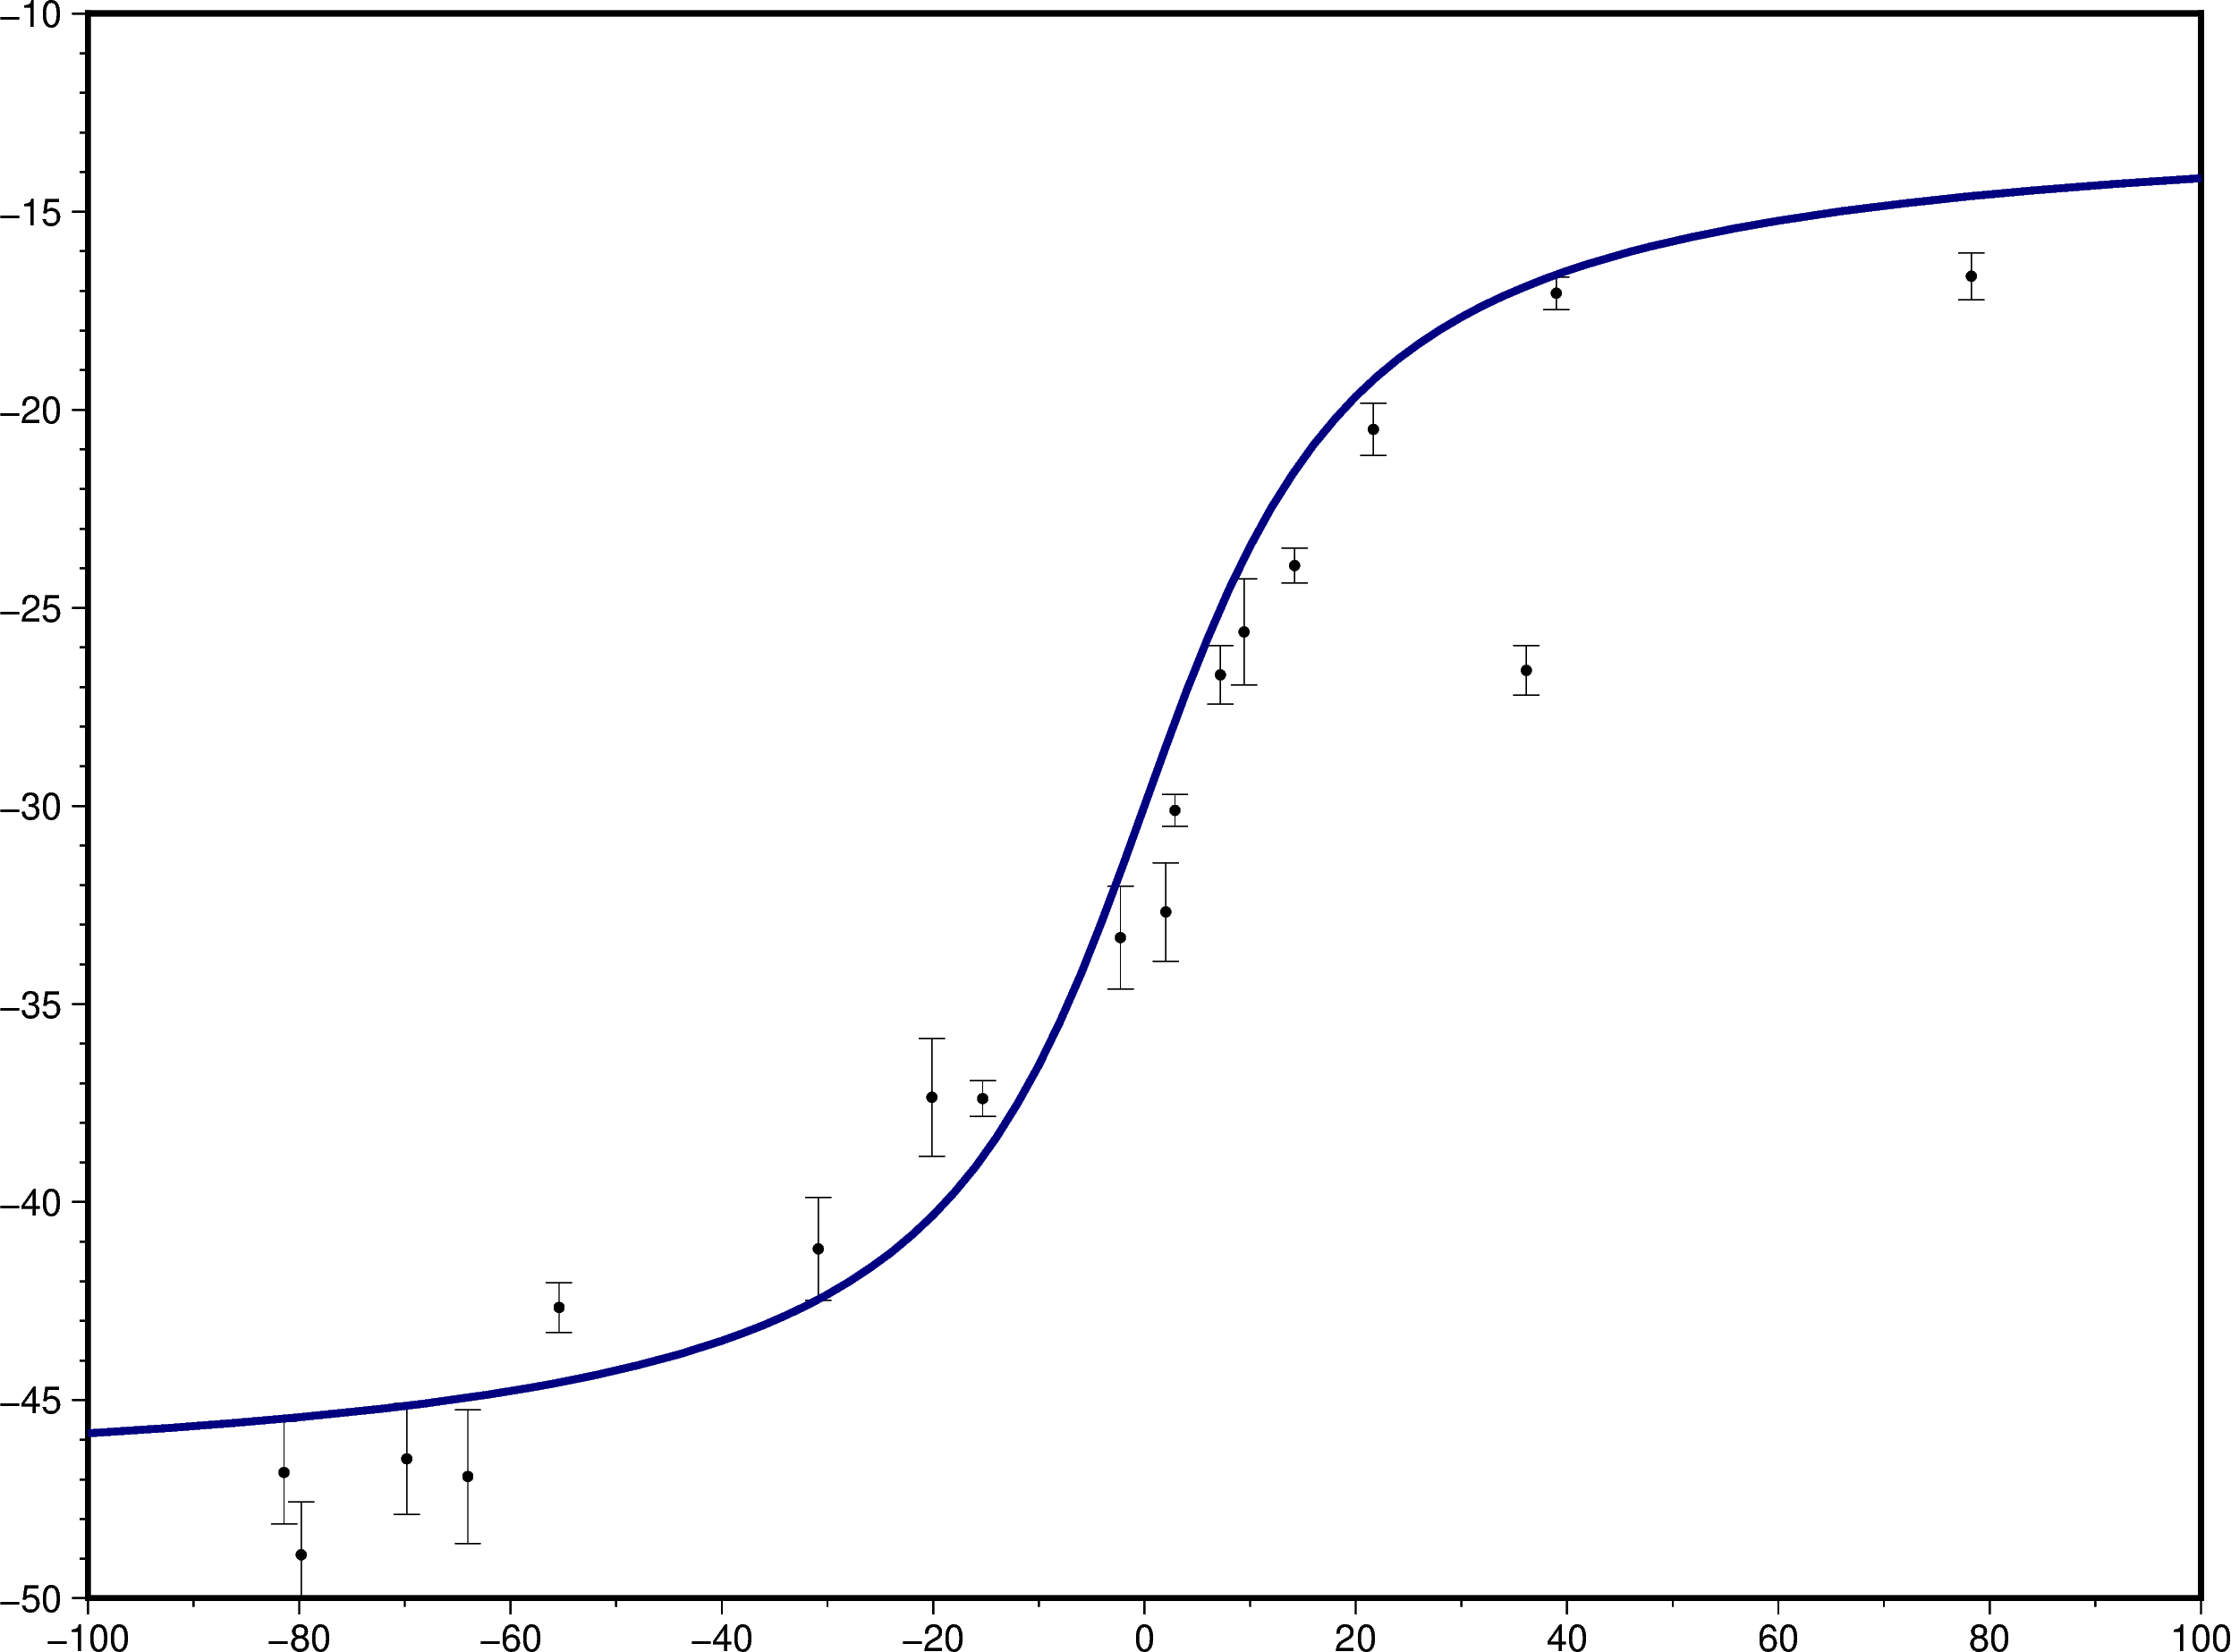

RSS = 192.07577943812979 (mm/yr)^2


In [7]:
# another empty grid cell for you to contemplate the emptiness of existence,
# or, alternately, evauluating the fit of simple geophysical models, here:

v=slip1d(35,15,-30,x)
model_v=slip1d(35,15,-30,x_gps)

RSS=np.sum((v_gps-model_v)**2)

region = [np.min(x), np.max(x), -50, -10]
fig = pygmt.Figure()
fig.basemap(region=region,projection='X20c/15c',frame=True)
fig.plot(data=np.vstack((x_gps,v_gps,v_gps_err)).T,style='c0.1c',fill='black',error_bar='y')
fig.plot(x=x,y=v,pen='2p,navy')
fig.show()

print("RSS =",RSS,"(mm/yr)^2")



In order to use all of this information to model the slip on the San Andreas fault, we want to set up a couple of loops to evaluate all of the combinations of locking depth and slip rate, and then a misfit (penalty) for each of them. Then, the model with the smallest misfit will be the best-fitting model!

The following code snippet will loop through all of your locking depths, as a starting point:

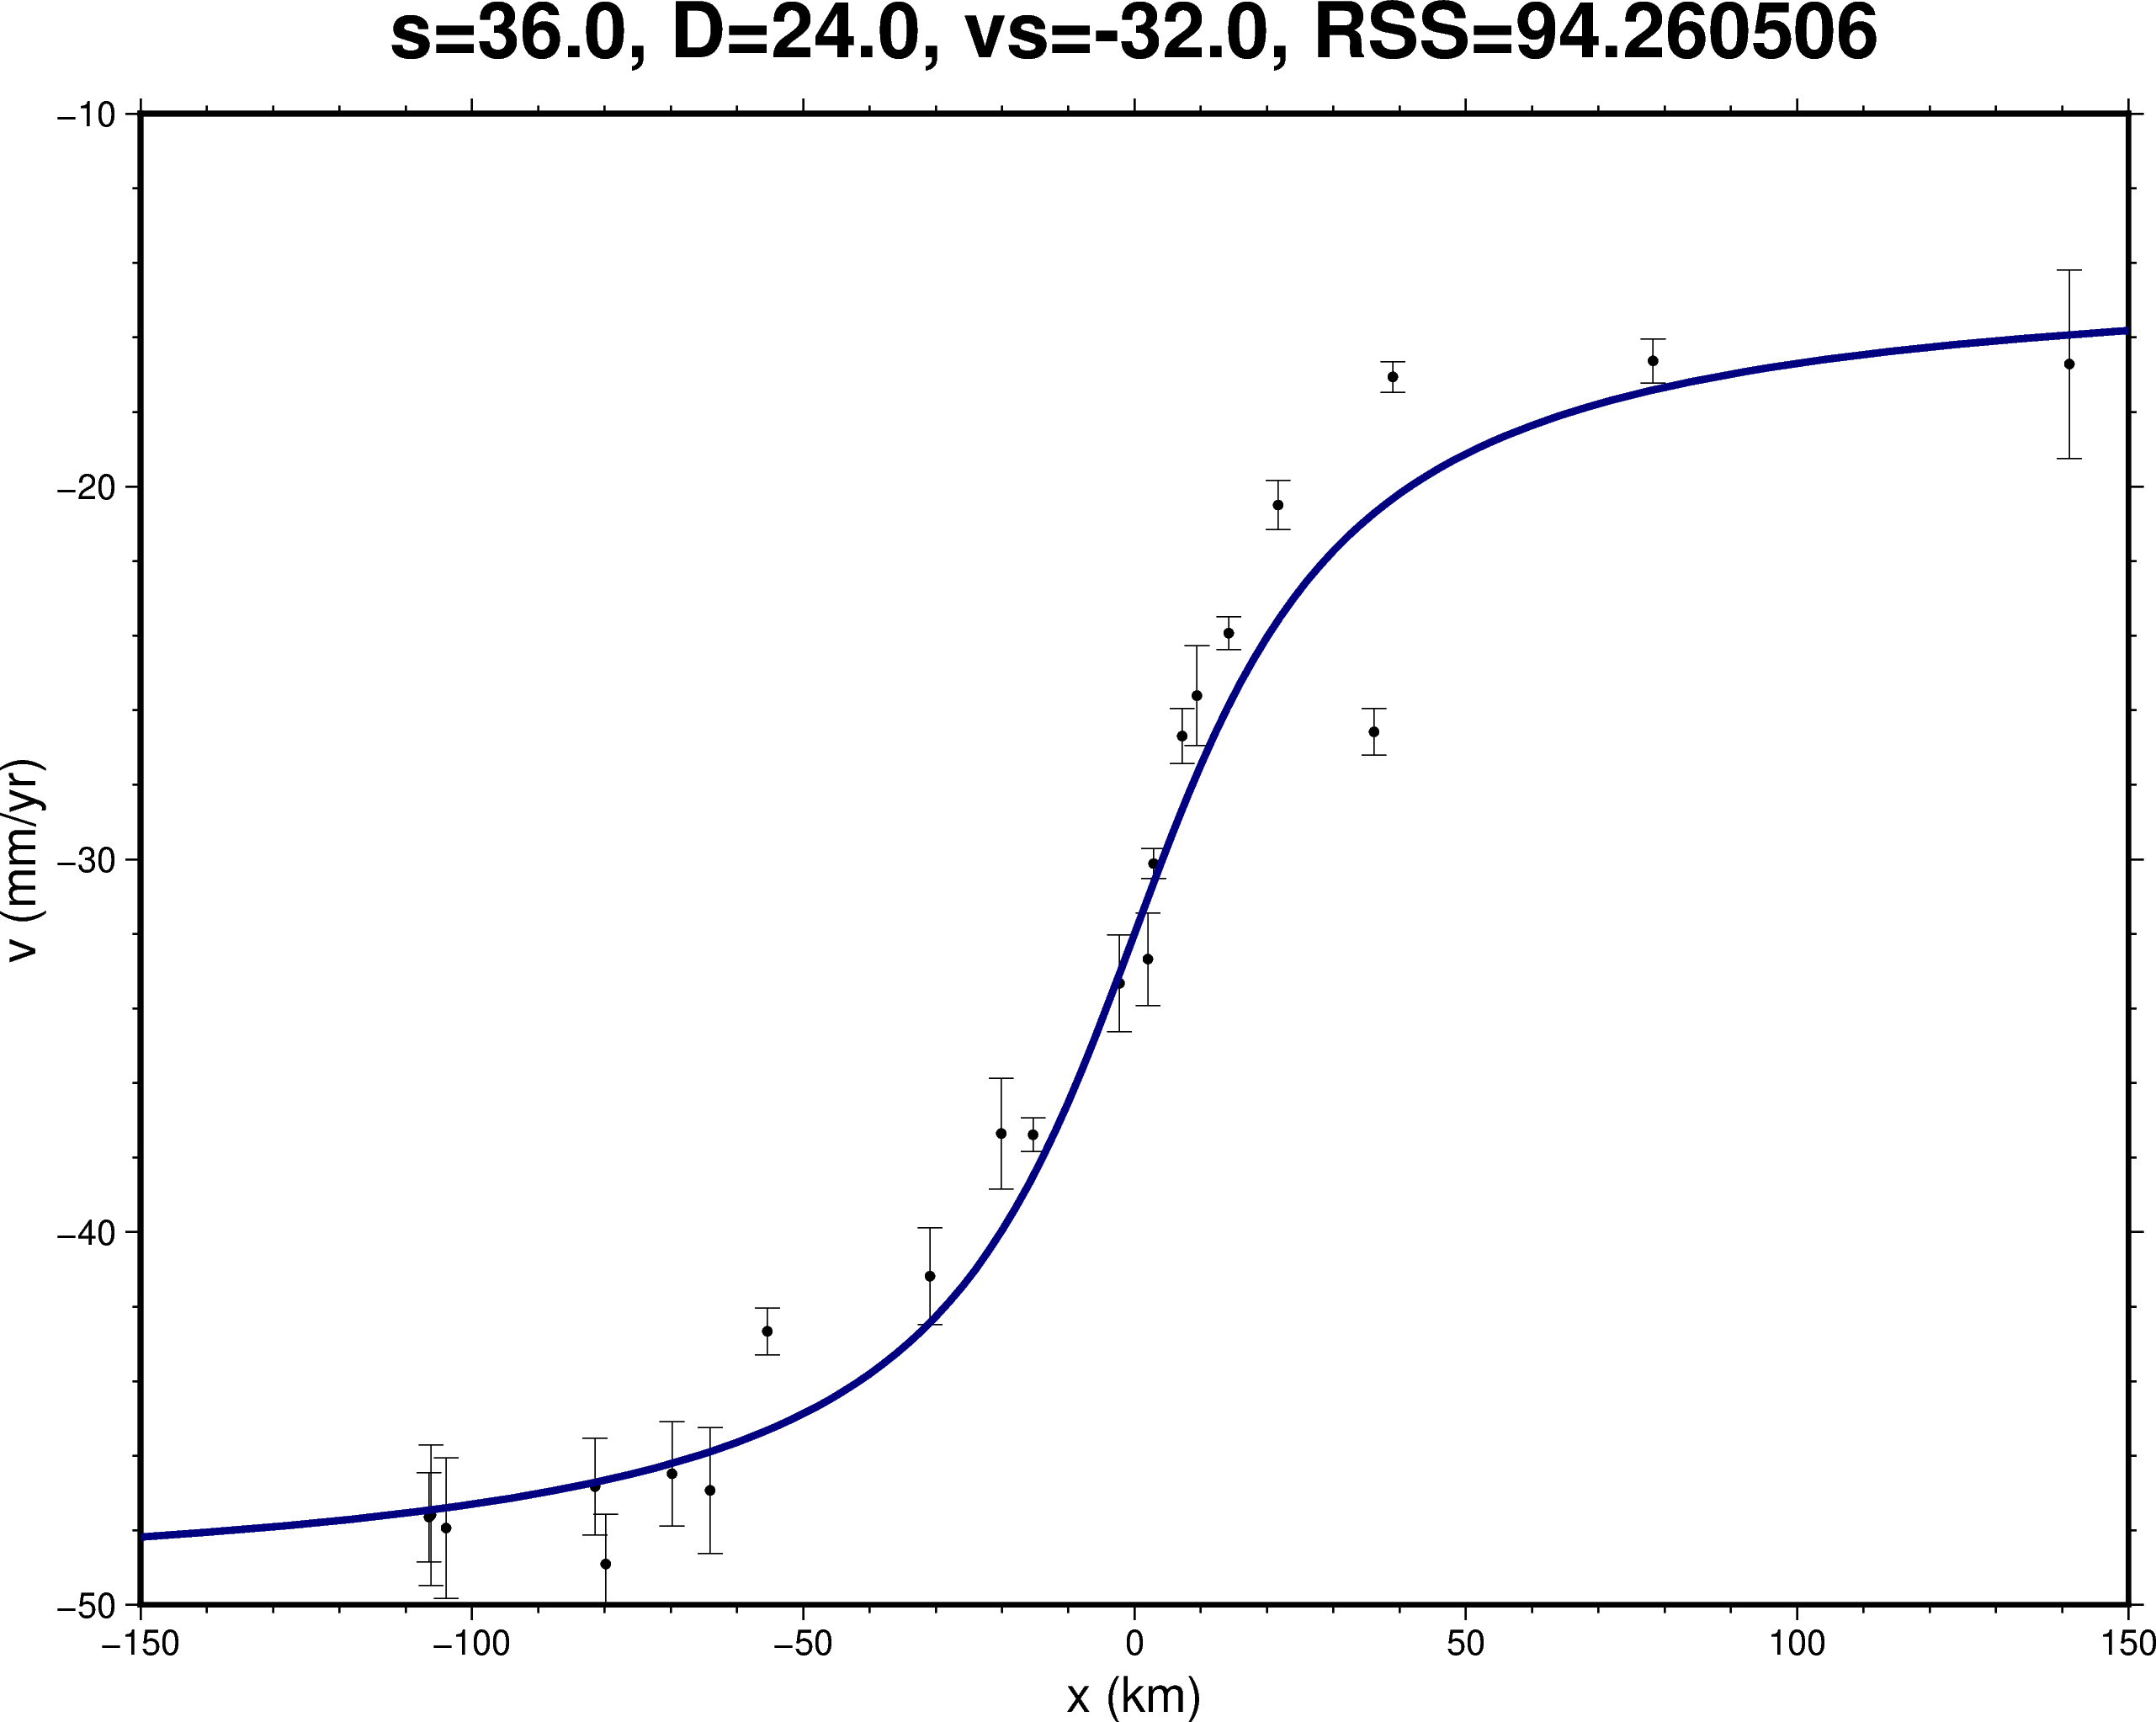

In [58]:
# set minimum and maximum slip rate bounds, plus a step size
smin=20
smax=40
sstep=1

# make a range of possible slip rate values
slip_rates=np.arange(smin,smax+sstep,sstep)

# set minimum and maximum locking depth bounds, plus a step size
Dmin=14
Dmax=28
Dstep=1

# make a range of possible locking depth values
locking_depths=np.arange(Dmin,Dmax+Dstep,Dstep)

# set minimum and maximum velocity shift bounds, plus a step size
vsmin=-35
vsmax=-28
vsstep=1

# make a range of possible velocity shift values
velocity_shifts=np.arange(vsmin,vsmax+vsstep,vsstep)

# let's try to keep track of the best model
best_s=-9999
best_D=-9999
best_vs=-9999
best_RSS=1e30

# set up an array to store RSS values and a counter
RSS_array=np.empty((len(slip_rates)*len(locking_depths)*len(velocity_shifts),4))                   
cnt=0

# loop through your slip rates, locking depths and velocity shifts
for s in slip_rates:
    for D in locking_depths:
        for vs in velocity_shifts:
            # evaluate the model at your gps locations with the trial parameter values
            model_v=slip1d(s,D,vs,x_gps)
            # calculate the RSS penalty
            RSS=np.sum((v_gps-model_v)**2)
            # store it in your array
            RSS_array[cnt,:]=[s, D, vs, RSS]
            # optionally (for debug purposes) display the results
#            print(s,D,vs,RSS)

            # update your best values, if you have a new best penalty value
            if RSS<best_RSS:
                best_s=s
                best_D=D
                best_vs=vs
                best_RSS=RSS

            # increment your counter 
            cnt+=1

# optionally write out the best parameter values
#print("best model: s = {0:f} mm/yr, D = {1:f} km, vs = {2:f} mm/yr, RSS = {3:f} (mm/yr)^2".format(best_s,best_D,best_vs,best_RSS))

x=np.linspace(-150,150,151)  # an array of distances in km
v=slip1d(best_s,best_D,best_vs,x)

region = [np.min(x), np.max(x), -50, -10]
fig = pygmt.Figure()
# include the best parameter results in the plot title 
fig.basemap(region=region,projection='X20c/15c',frame=['WeSn+ts={0:4.1f}, D={1:4.1f}, vs={2:5.1f}, RSS={3:f}'.format(best_s,best_D,best_vs,best_RSS),
                                                       'xa50f10+lx (km)', 'ya10f2+lv (mm/yr)'])
fig.plot(data=np.vstack((x_gps,v_gps,v_gps_err)).T,style='c0.1c',fill='black',error_bar='y')
fig.plot(x=x,y=v,pen='2p,navy')
fig.show()

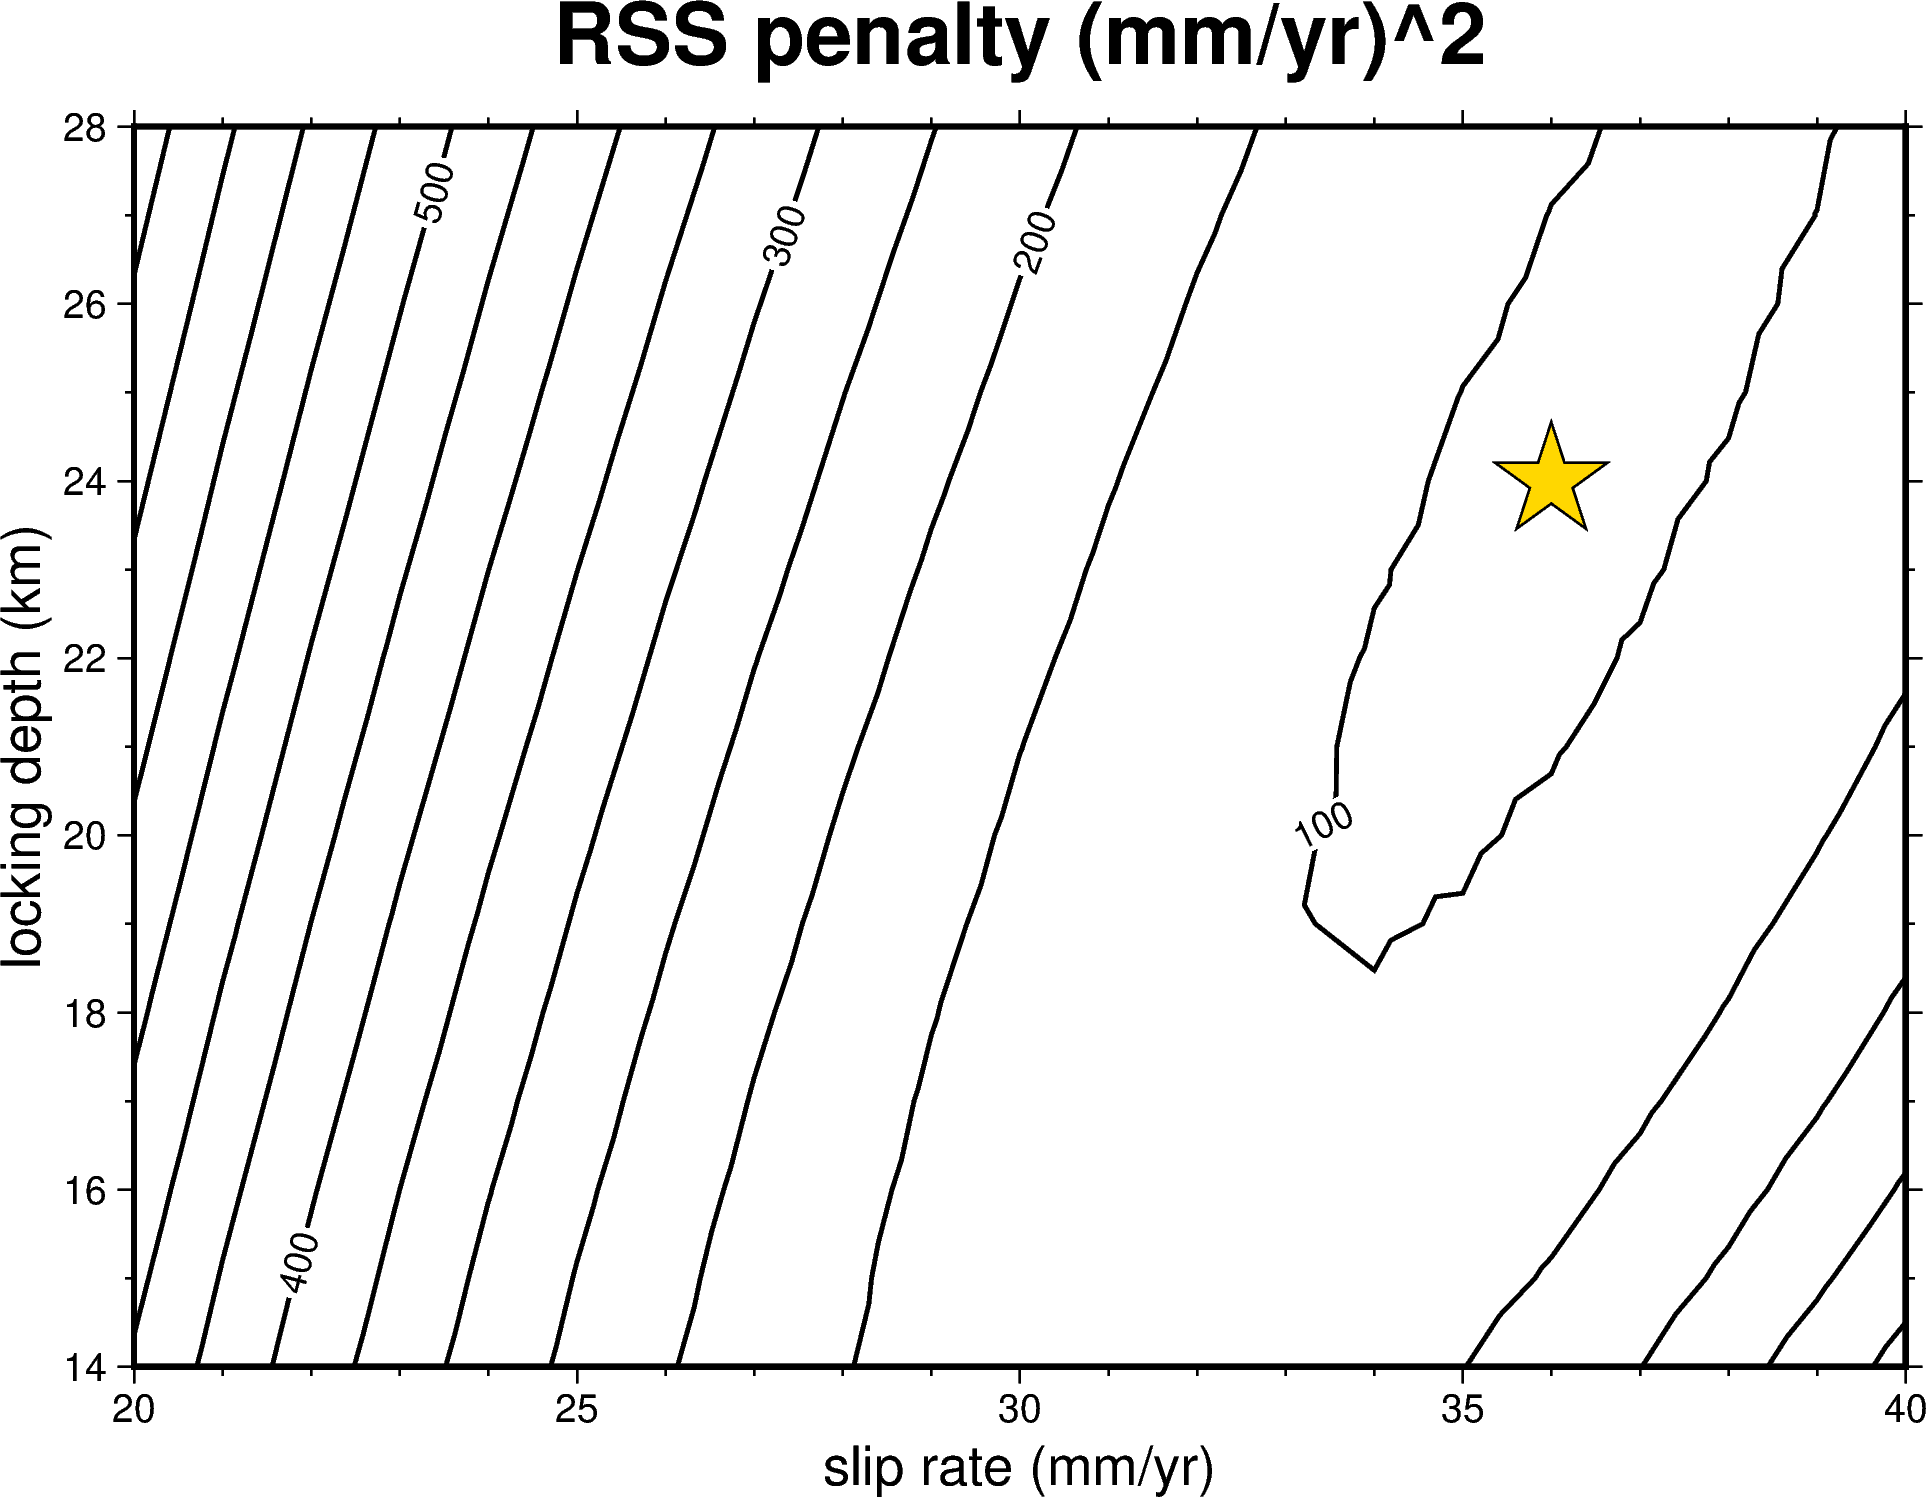

In [59]:
# a code cell to wonder about plotting the penalty function (i.e. the misfit)

# select the rows of RSS array that have the best velocity shift
RSS_array_best_vs=RSS_array[RSS_array[:,2]==best_vs]

# and let's plot a contour plot!
region=[smin, smax, Dmin, Dmax]
fig = pygmt.Figure()
fig.basemap(region=region, projection='x0.75c',frame=['WeSn+tRSS penalty (mm/yr)^2','xa5f1+lslip rate (mm/yr)','ya2f1+llocking depth (km)'])
# plot contours, using our best velocity shift results
fig.contour(data=RSS_array_best_vs[:,(0,1,3)],pen='1p')
# and plot a star for our best parameter values
fig.plot(x=best_s,y=best_D,style='a1c',fill='gold',pen='0.5p')
fig.show()


In [44]:
whos

Variable            Type        Data/Info
-----------------------------------------
D                   int64       25
Dmax                int         25
Dmin                int         10
Dstep               int         1
RSS                 float64     349.89634110493404
RSS_array           ndarray     1408x4: 5632 elems, type `float64`, 45056 bytes
RSS_array_3D        ndarray     11x16x8: 1408 elems, type `float64`, 11264 bytes
RSS_array_best_vs   ndarray     176x4: 704 elems, type `float64`, 5632 bytes
best_D              int64       24
best_RSS            float64     94.26050645607309
best_s              int64       36
best_vs             int64       -32
cnt                 int         1408
dx                  float64     0.6427876096865395
dy                  float64     -0.7660444431189779
fig                 Figure      <pygmt.figure.Figure object at 0x7fea0c481510>
horiz_gps           ndarray     22x4: 88 elems, type `float64`, 704 bytes
locking_depths      ndarray     16: 16 

## References


Savage, J. C., and R. O. Burford (1973), Geodetic determination of relative plate motion in central California, J. Geophys. Res., 78(5), 832–845, [doi:10.1029/JB078i005p00832](https://doi.org/10.1029/JB078i005p00832). 

Schmalzle, G., T. Dixon, R. Malservisi, and R. Govers (2006), Strain accumulation across the Carrizo segment of the San Andreas Fault, California: Impact of laterally varying crustal properties, J. Geophys. Res., 111, B05403, [doi:10.1029/2005JB003843]( https://doi.org/10.1029/2005JB003843).  
